In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
import scipy.signal 

import time

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


%matplotlib inline
%load_ext autoreload
%autoreload 2

(21918, 4)


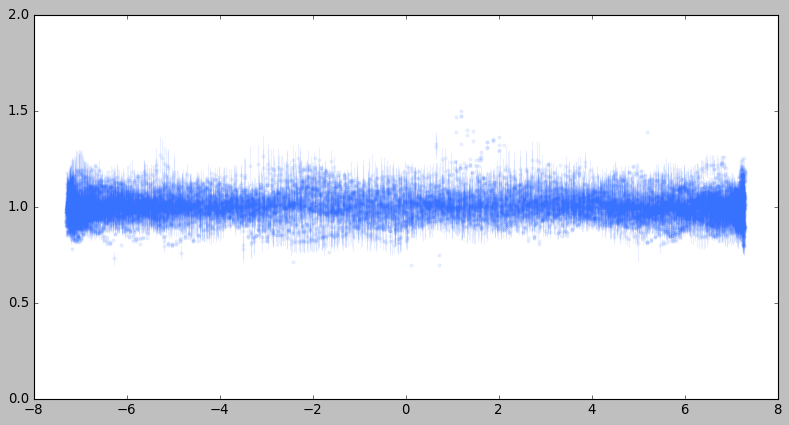

In [179]:
data = np.genfromtxt("./heliocentricLat_171_corrected_2008onwards.txt")
badDataMask = (data[:,1] <=0.5) | (data[:,1] > 1.75)
data = data[~badDataMask]

print(np.shape(data))
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(data[:,0],data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
ax.set_ylim(0,2)
plt.show()

# uniform model
def uniform_ptransform(fitparam):
    """
    transforms a sample drawn from the unit cube [0, 1) to the appropriate uniform prior for the intercept of the flat line
    which I have chosen to be U(0.95, 1.05)
    """
    lineparam = fitparam*(1.05-0.95) + 0.95
    return lineparam

# linear model
def linear_ptransform(fitparams):
    """
    prior on slope is U(-0.025, 0.025)
    prior in intercept is U(0.95,1.05)
    """
    slope = fitparams[0]*(0.025 + 0.025) - 0.025
    intercept = fitparams[1]*(1.05-0.95) + 0.95
    return np.array((slope, intercept))

# linear in cos(lat) model
def linearcos_ptransform(fitparams):
    """
    prior on slope is U(-10,10)
    prior in intercept is U(0.95,1.05)
    """
    slope = fitparams[0]*(10 + 10) - 10
    intercept = fitparams[1]*(1.05-0.95) + 0.95
    return np.array((slope, intercept))

# gaussian log likelihood fn for each model
def uniform_log_likelihood(intercept, norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    following Hogg et al. 2010 chapter 7
    Assuming no covariance between data points and no uncertainty on latitude
    
    Inputs:
    intercept, y, yerr
                
    Returns:
    Log likelihood calculated for these parameters.
    """
    model_flux = intercept
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll

def linear_log_likelihood(params, lat=np.abs(data[:,0]), norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    Inputs:
    params = (slope, intercept); flux, fluxerr
    """
    model_flux = params[0]*lat + params[1]
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll

def linearcos_log_likelihood(params, coslat = (np.cos(data[:,0]*(np.pi/180.)) - np.cos(data[0,0]*(np.pi/180.))), norm_flux=data[:,1], norm_fluxerr=data[:,2]):
    """
    Inputs:
    params = (slope, intercept); flux, fluxerr
    """
    model_flux = params[0]*coslat + params[1]
    ll  = -np.sum(0.5*np.log(2*np.pi*norm_fluxerr**2)) - np.sum(((norm_flux - model_flux)**2)/(2*norm_fluxerr**2))
    return ll


In [180]:
def compareModels(likelihoodFunctionList, priorTransformFunctionList, ndimList):
    log_zs = []
    log_zerrs = []
    means = []
    covs = []
    samplearrs = []
    for i in range(len(likelihoodFunctionList)):
        sampler = dynesty.DynamicNestedSampler(loglikelihood=likelihoodFunctionList[i], prior_transform=priorTransformFunctionList[i], ndim=ndimList[i], nlive=1000)
        sampler.run_nested()
        sresults = sampler.results

        tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
        cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)


        log_zs.append(sresults['logz'][-1])
        log_zerrs.append(sresults['logzerr'][-1])

        samples = sresults.samples  # samples
        weights = sresults.importance_weights()

        # Compute 10%-90% quantiles.
        quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
                     for samps in samples.T]
        
        # Compute weighted mean and covariance.
        mean, cov = dyfunc.mean_and_cov(samples, weights)
        means.append(mean)
        covs.append(cov)
        
        # Resample weighted samples.
        samples_equal = sresults.samples_equal()
        samplearrs.append(samples_equal)

    return log_zs, log_zerrs, means, covs, samplearrs

20339it [00:13, 1472.01it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 57629 | eff(%): 35.280 | loglstar: -35829665.098 <   -inf < -35829664.769 | logz:   -inf +/-  0.434 | stop:  0.965]
28558it [00:14, 1951.34it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 73322 | eff(%): 38.931 | loglstar: -35414282.296 <   -inf < -35414281.944 | logz:   -inf +/-  0.518 | stop:  0.936]
27720it [00:14, 1916.57it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 72246 | eff(%): 38.359 | loglstar: -35339161.803 <   -inf < -35339161.430 | logz:   -inf +/-  0.444 | stop:  0.917]


[-35829670.924921885, -35414296.405316345, -35339174.760120064]
[1.00173937]
8.318185312772286e-06
1.0017394375579296
8.23481333656062e-06



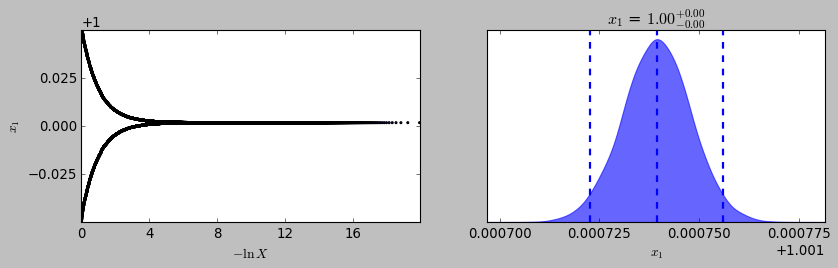

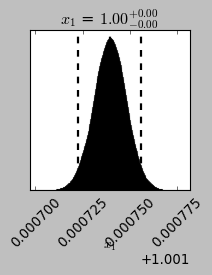

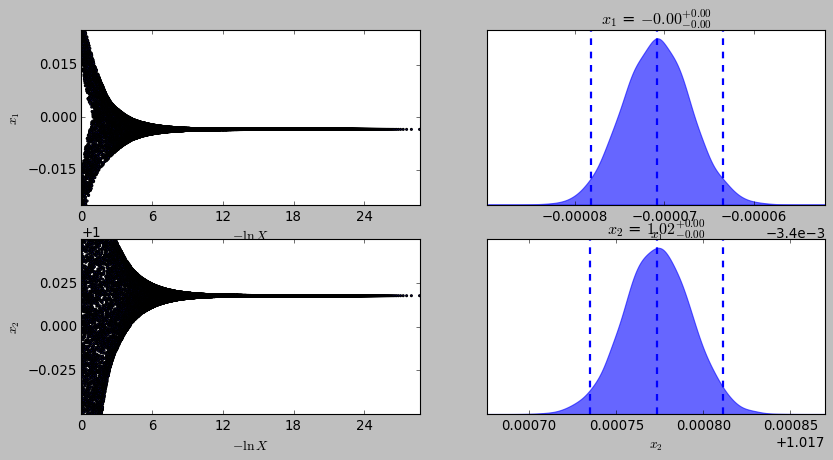

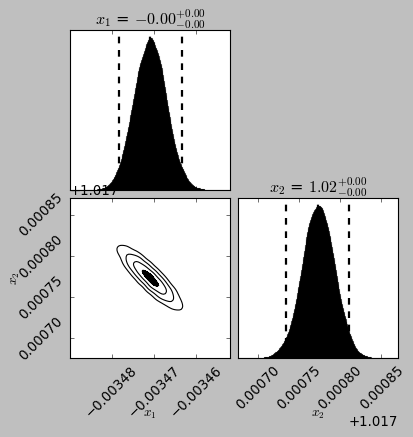

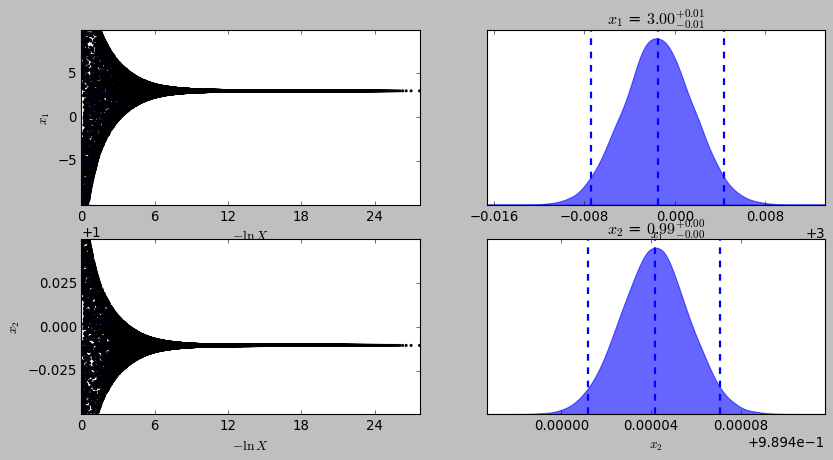

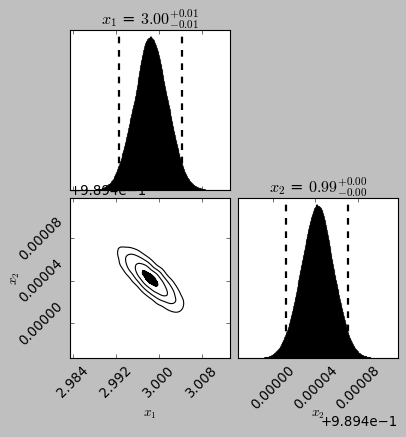

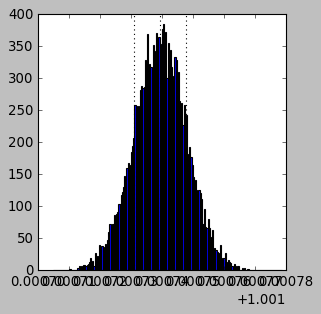

[-0.00347088  1.01777334]
3.7902777085506434e-06
-0.0034708530857871164
3.660191460898299e-06



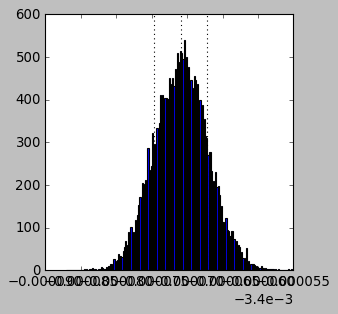

1.9010516993045457e-05
1.0177733445113482
1.920432678592654e-05



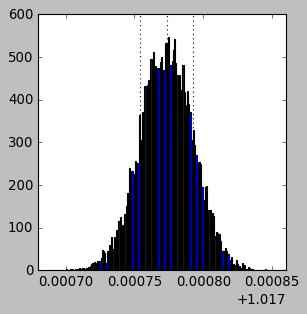

[2.99848986 0.98944163]
0.003023802683565613
2.9984799474206376
0.003054431796698509



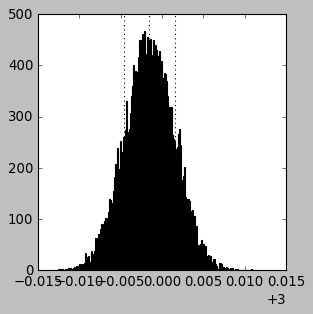

1.5060959053125877e-05
0.9894416389199159
1.4877142362923479e-05



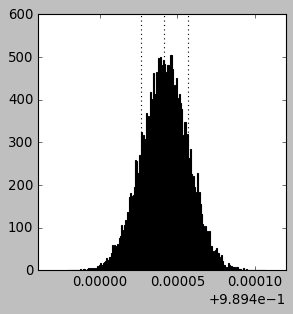

In [184]:
modelNames = ['uniform','linear','linearcos']
log_zs, log_zerrs, means, covs, samplearrs = compareModels(likelihoodFunctionList=[uniform_log_likelihood, linear_log_likelihood, linearcos_log_likelihood],
                                                        priorTransformFunctionList=[uniform_ptransform, linear_ptransform, linearcos_ptransform],
                                                        ndimList=[1,2,2])

print(log_zs)

for i in range(len(modelNames)):
    print(means[i])
    ncols = np.shape(samplearrs[i])[1]
    for j in range(ncols):
        p16 = np.percentile(samplearrs[i][:,j], 16)
        p50 = np.percentile(samplearrs[i][:,j], 50)
        p84 = np.percentile(samplearrs[i][:,j], 84)
        print(p50-p16)
        print(p50)
        print(p84-p50)
        print("")
        '''
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        ax.hist(samplearrs[i][:,j],bins=200)
        ax.axvline(p16,color='k',linestyle=':')
        ax.axvline(p50,color='k',linestyle=':')
        ax.axvline(p84,color='k',linestyle=':')
        plt.show()
        '''

In [182]:
print(log_zs[1] - log_zs[0])
print(log_zs[2] - log_zs[0])
print(log_zs[2] - log_zs[1])

415374.83935119957
490495.99889642745
75121.15954522789


In [185]:
4.9/1.19

4.11764705882353

In [187]:
3.2*38.67

123.74400000000001

19385it [00:13, 1478.18it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 56039 | eff(%): 34.591 | loglstar: -5844715.976 <   -inf < -5844715.620 | logz:   -inf +/-  0.039 | stop:  0.971] 


Summary
niter: 19385
ncall: 55941
eff(%): 34.591
logz: -5844720.713 +/-  0.080
[1.00592813] [[4.33040864e-10]]
(19385, 1)
()


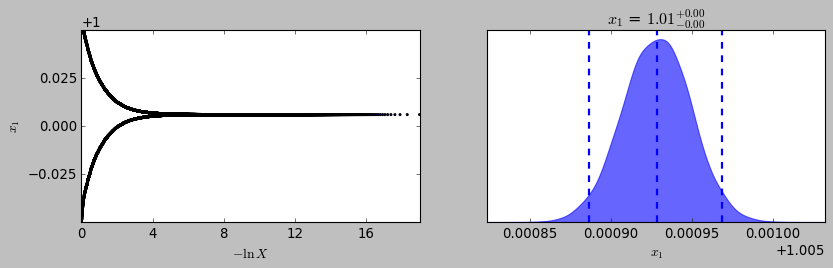

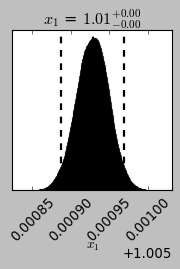

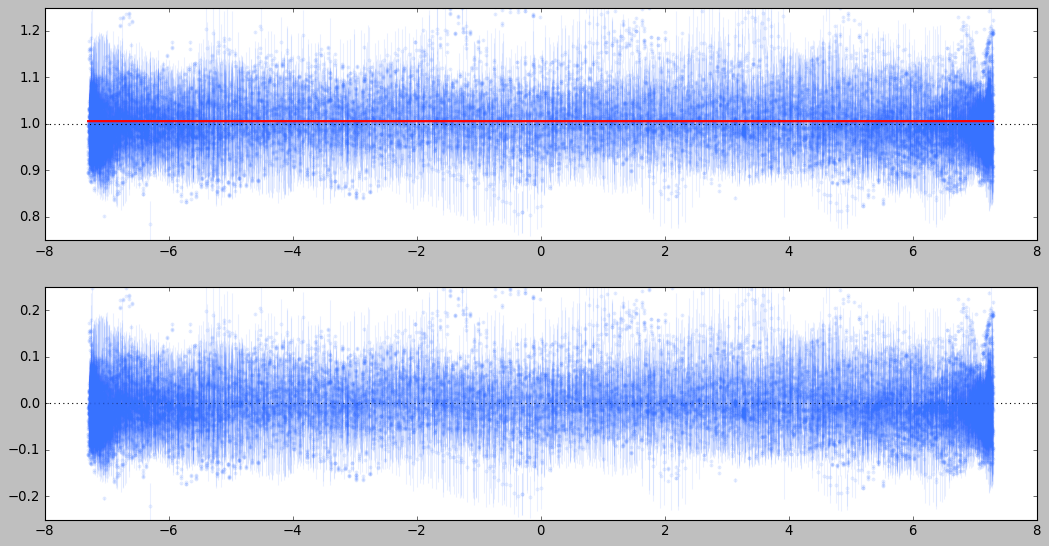

In [154]:
# Fit the uniform model.
uniform_ndim = 1

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=uniform_log_likelihood, prior_transform=uniform_ptransform, ndim=uniform_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print(mean,cov)

# Resample weighted samples.
samples_equal = sresults.samples_equal()
print(np.shape(samples_equal))

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)
print(np.shape(results_sim))

#plot data, model, residuals
mean_model = mean[0]*np.ones_like(data[:,0])

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(data[:,0],data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(data[:,0],mean_model, 'r-', lw=2,zorder=3)
for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    axes[0].plot(data[:,0], samples_equal[random_draw][0]*np.ones_like(data[:,0]),color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(data[:,0],data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)
plt.show()

26781it [00:17, 1503.45it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 71377 | eff(%): 37.491 | loglstar: -5720928.079 <   -inf < -5720927.707 | logz:   -inf +/-  0.071 | stop:  0.928]  


Summary
niter: 26781
ncall: 71150
eff(%): 37.491
logz: -5720940.288 +/-  0.037


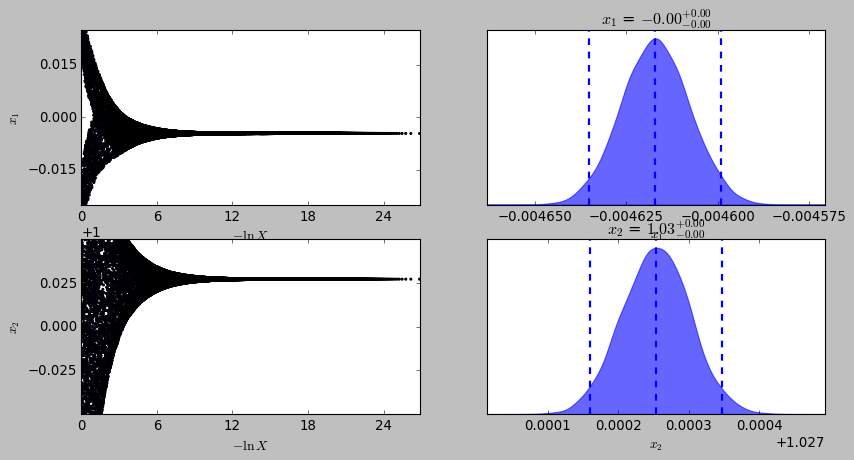

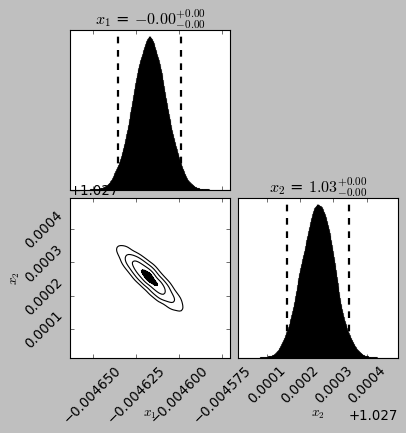

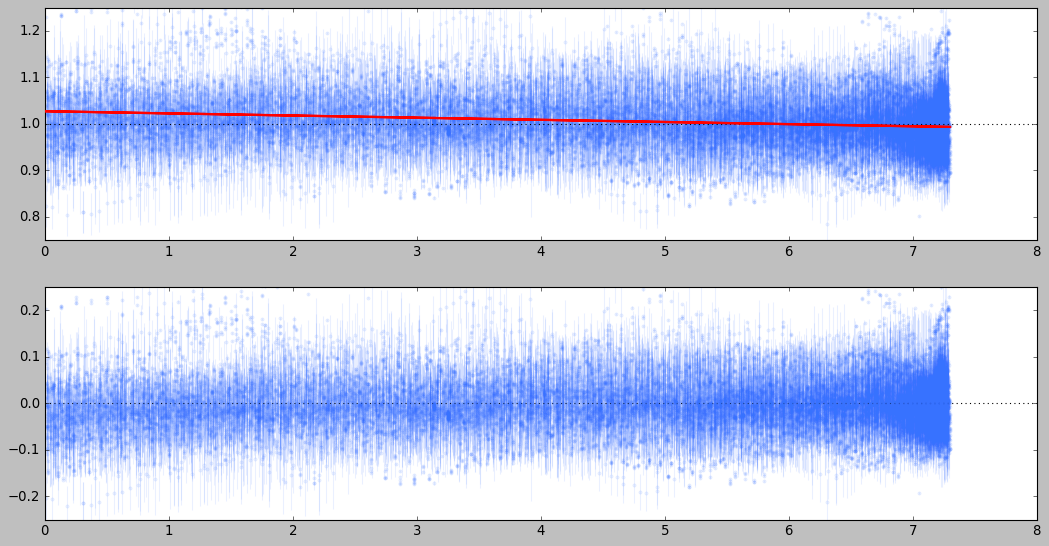

In [137]:
# Fit the linear model.
linear_ndim = 2

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=linear_log_likelihood, prior_transform=linear_ptransform, ndim=linear_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = sresults.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)

#plot data, model, residuals
mean_model = mean[0]*np.abs(data[:,0]) + mean[1]

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(np.abs(data[:,0]),data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(np.abs(data[:,0]),mean_model, 'r-', lw=2,zorder=3)
for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    trial_model = samples_equal[random_draw][0]*np.abs(data[:,0]) + samples_equal[random_draw][1]
    axes[0].plot(np.abs(data[:,0]), trial_model,color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(np.abs(data[:,0]),data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)
plt.show()

25698it [00:16, 1558.27it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 68305 | eff(%): 37.571 | loglstar: -5722596.878 <   -inf < -5722596.504 | logz:   -inf +/-  0.103 | stop:  0.938] 


Summary
niter: 25698
ncall: 68160
eff(%): 37.571
logz: -5722608.129 +/-  0.051


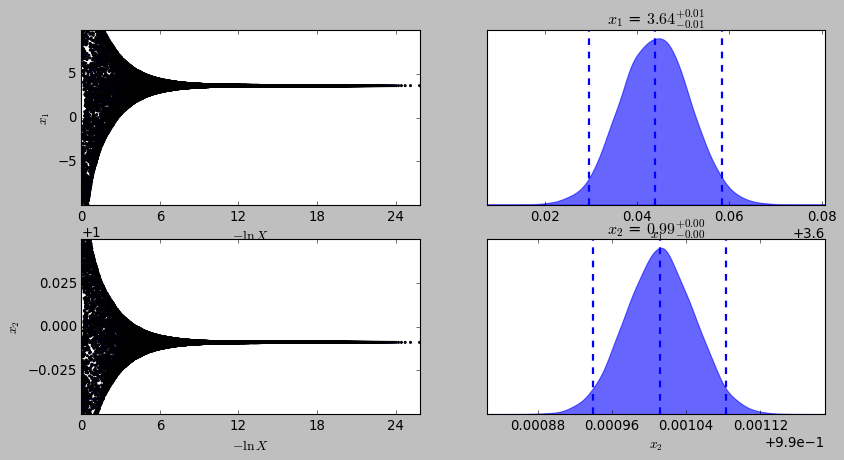

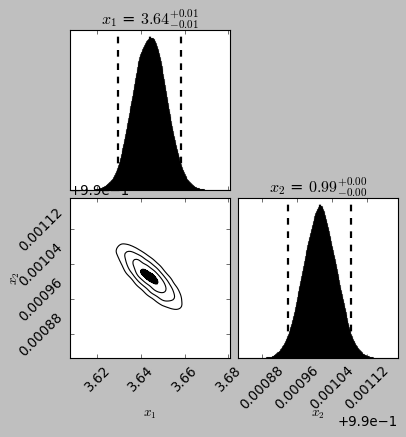

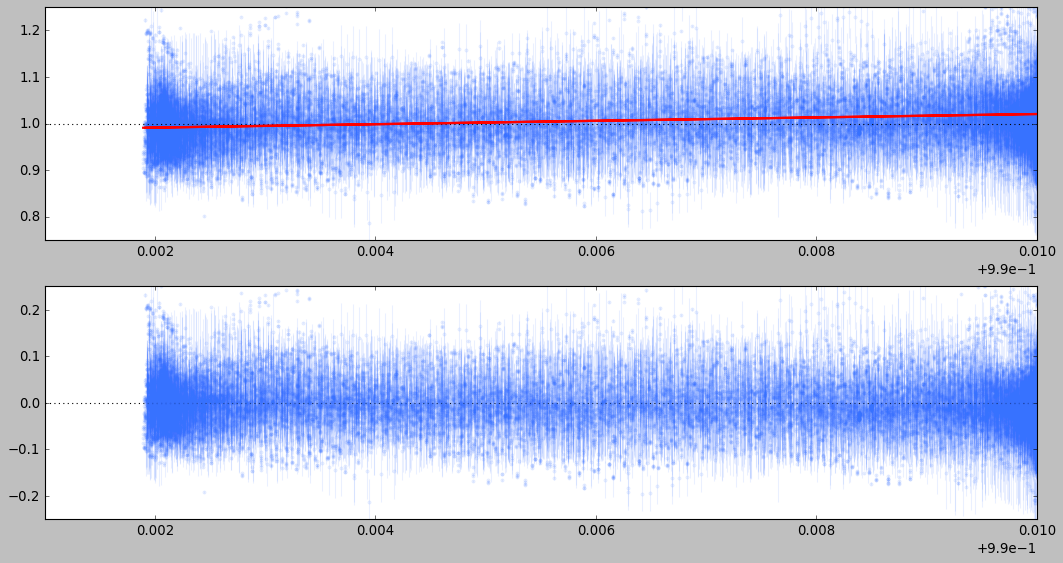

In [138]:
# Fit the linear in cos(lat) model.
linearcos_ndim = 2

# "Static" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglikelihood=linearcos_log_likelihood, prior_transform=linearcos_ptransform, ndim=linearcos_ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

sresults.summary()

#rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,show_titles=True)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True)

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = sresults.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)

#plot data, model, residuals
x = np.cos(data[:,0]*(np.pi/180.))
x0 = np.cos(data[0,0]*(np.pi/180.))

mean_model = mean[0]*(x-x0) + mean[1]

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].errorbar(x,data[:,1],data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1,zorder=1)
axes[0].axhline(1,ls=':',color='k',zorder=2)
axes[0].plot(x,mean_model, 'r-', lw=2,zorder=3)

for i in range(100):
    random_draw = np.random.choice(np.shape(samples_equal)[0])
    trial_model = samples_equal[random_draw][0]*(x-x0) + samples_equal[random_draw][1]
    axes[0].plot(x, trial_model,color='r',ls='-',lw=0.1,zorder=4)
axes[0].set_ylim(0.75,1.25)

axes[1].errorbar(x,data[:,1]-mean_model,data[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
axes[1].axhline(0,ls=':',color='k',zorder=2)
axes[1].set_ylim(-0.25,0.25)

plt.show()